In [ ]:
#hello world!

In [ ]:
#mount gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset

Import data

In [ ]:
train_path = "/content/gdrive/MyDrive/ECE_3rd_Year/APS360/Project/Groupwork APS360/baselineset/base/train"
validation_path = "/content/gdrive/MyDrive/ECE_3rd_Year/APS360/Project/Groupwork APS360/baselineset/base/val"
test_path = "/content/gdrive/MyDrive/ECE_3rd_Year/APS360/Project/Groupwork APS360/baselineset/test"

transform = transforms.Compose([transforms.Resize((50, 50)), transforms.ToTensor()])  
train_data_set = torchvision.datasets.ImageFolder(train_path, transform=transform)
test_data_set = torchvision.datasets.ImageFolder(test_path, transform=transform)
validation_data_set = torchvision.datasets.ImageFolder(validation_path, transform=transform)


batch_size = 32
numworkers = 1

#Show the size of each data_set
print("Train image number: ", len(train_data_set))
print("Validation image number: ", len(validation_data_set))
print("Test image number: ", len(test_data_set))

Train image number:  600
Validation image number:  125
Test image number:  1470


In [ ]:
classes = ["with", "without", "wrong"]

train_loader = torch.utils.data.DataLoader(train_data_set, batch_size=batch_size, num_workers=1, shuffle= True)
val_loader = torch.utils.data.DataLoader(validation_data_set, batch_size=batch_size, num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data_set, batch_size=batch_size, num_workers=1, shuffle=True)


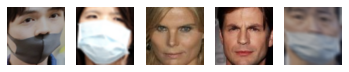

In [ ]:
k = 0
for images, labels in test_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 4:
        break

Baseline model

In [ ]:
class Baseline(nn.Module):
  def __init__(self):
    self.name = "Baseline"
    super(Baseline, self).__init__()
    self.conv1 = nn.Conv2d(3, 5, 2, 2, 0)
    self.fc1 = nn.Linear(5 * 25 * 25, 3)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = x.view(-1, 5 * 25 * 25)
    x = self.fc1(x)

    return x

Get Accuracy

In [ ]:
#get accuracy
#This function returns the performance on a set of data
def get_accuracy(model, loader):
  data = loader

  correct_num = 0
  total_num = 0
  for imgs, lable in data:

    #############################################
      #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      lable = lable.cuda()
      #############################################

    output = model(imgs)

    #Select index with maximum score which will be the prediction result
    pred = output.max(1, keepdim=True)[1]
    correct_num += pred.eq(lable.view_as(pred)).sum().item()
    total_num += imgs.shape[0]
  return correct_num / total_num 


Train

In [ ]:
def train_net(net, train, validation, batch_size=32, learning_rate=0.001, num_epochs=10):

  ############################################################################
  # Train the model on 9 letters
  classes = ["with_mask", "without_mask", "wrong_mask"]

  ############################################################################
  # Fixed PyTorch random seed for reproducible result
  torch.manual_seed(1)

  ############################################################################
  # Obtain data loader from the data_set
  train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, num_workers=numworkers, shuffle=True)
  validation_loader = torch.utils.data.DataLoader(validation, batch_size=batch_size, num_workers=numworkers, shuffle=True)

  ############################################################################
  # Define loss function and optimizer
  # In this classification problem, we use crossEntropyLoss
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

  ############################################################################
  #setup arrays to store the loss and error
  iters, losses, train_acc, val_acc = [], [], [], []

  ############################################################################
  #Strat the training process
  print("Start the training process!")

  n = 0 #number of iterations
  for epoch in range(num_epochs):
    
    for imgs, lable in iter(train_loader):


      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        lable = lable.cuda()
      #############################################
      
      # Forward pass, backward pass, and optimize
      output = net(imgs)                        # forward pass
      loss = criterion(output, lable)                 # compute total loss
      loss.backward()                          # backward pass
      optimizer.step()                          # update each parameters
      optimizer.zero_grad()                        # zero the parameter gradients

    #save current information
    iters.append(n)
    losses.append(float(loss)/batch_size)                                       #compute average loss
    train_acc.append(get_accuracy(model, train_loader))                              #compute train accuracy
    val_acc.append(get_accuracy(model, validation_loader))                             #compute validation accuracy
    print("epoch number = ", n+1, "Training_accuracy = ", train_acc[n], "loss = ", losses[n], "validation_acc = ", val_acc[n])
    n += 1                                                      #update epochs numbers
    model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
    torch.save(model.state_dict(), model_path)                                   #save the check points                            

  ############################################################################
  #plotting
  plt.title("Training Curve")
  plt.plot(iters, losses, label="train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.plot(iters, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))

CUDA is available! Training on GPU ...
Start the training process!
epoch number =  1 Training_accuracy =  0.32666666666666666 loss =  0.008604669012129307 validation_acc =  0.336
epoch number =  2 Training_accuracy =  0.295 loss =  0.008574757725000381 validation_acc =  0.312
epoch number =  3 Training_accuracy =  0.42 loss =  0.00833406113088131 validation_acc =  0.304
epoch number =  4 Training_accuracy =  0.4066666666666667 loss =  0.00846127513796091 validation_acc =  0.368
epoch number =  5 Training_accuracy =  0.6916666666666667 loss =  0.008035629987716675 validation_acc =  0.568
epoch number =  6 Training_accuracy =  0.69 loss =  0.00771358935162425 validation_acc =  0.6
epoch number =  7 Training_accuracy =  0.6883333333333334 loss =  0.007469652686268091 validation_acc =  0.624
epoch number =  8 Training_accuracy =  0.705 loss =  0.007617199327796698 validation_acc =  0.624
epoch number =  9 Training_accuracy =  0.68 loss =  0.007290537469089031 validation_acc =  0.64
epoch n

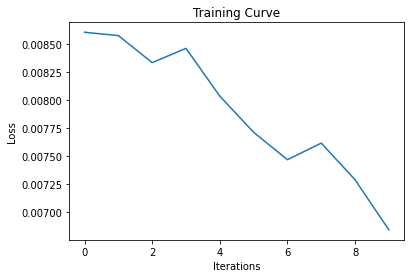

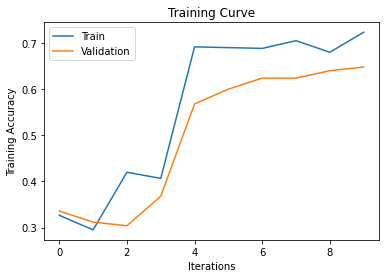

Final Training Accuracy: 0.7233333333333334
Final Validation Accuracy: 0.648


In [ ]:
use_cuda = True
model = Baseline()
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available! Training on GPU ...')
else:
  print('CUDA is not available. Training on CPU ...')

train_net(model, train_data_set, validation_data_set, batch_size=128, learning_rate=0.001, num_epochs=10)

In [ ]:
best_model = Baseline().cuda()
best_model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format("Baseline", 128, 0.001, 9)
state = torch.load(best_model_path)
best_model.load_state_dict(state)
test_acc = get_accuracy(best_model, test_loader)
print("The test accuracy of baseline model is: ", test_acc)

The test accuracy of baseline model is:  0.7108843537414966


In [ ]:
test_with_p = "/content/gdrive/MyDrive/ECE_3rd_Year/APS360/Project/test"
test_without_p = "/content/gdrive/MyDrive/ECE_3rd_Year/APS360/Project/without"
test_wrong_p = "/content/gdrive/MyDrive/ECE_3rd_Year/APS360/Project/wrong"
transform = transforms.Compose([transforms.Resize((50, 50)), transforms.ToTensor()])  
test_with_set = torchvision.datasets.ImageFolder(test_with_p, transform=transform)
test_without_set = torchvision.datasets.ImageFolder(test_without_p, transform=transform)
test_wrong_set = torchvision.datasets.ImageFolder(test_wrong_p, transform=transform)
test_with_loader = torch.utils.data.DataLoader(test_with_set, batch_size=batch_size, num_workers=1, shuffle=True)
test_without_loader = torch.utils.data.DataLoader(test_without_set, batch_size=batch_size, num_workers=1, shuffle=True)
test_wrong_loader = torch.utils.data.DataLoader(test_wrong_set, batch_size=batch_size, num_workers=1, shuffle=True)
test_with_acc = get_accuracy(best_model, test_with_loader)
test_without_acc = get_accuracy(best_model, test_without_loader)
test_wrong_acc = get_accuracy(best_model, test_wrong_loader)
print("The test accuracy of baseline model on with is: ", test_with_acc)
print("The test accuracy of baseline model on without is: ", test_without_acc)
print("The test accuracy of baseline model on wrong is: ", test_wrong_acc)

The test accuracy of baseline model on with is:  0.5935613682092555
The test accuracy of baseline model on without is:  0.8229376257545271
The test accuracy of baseline model on wrong is:  0.707983193277311
